<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess the Data

In [2]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()
# Normalize the pixel values
xtrain = xtrain.astype(np.float32)/255.0
xtest = xtest.astype(np.float32)/255.0

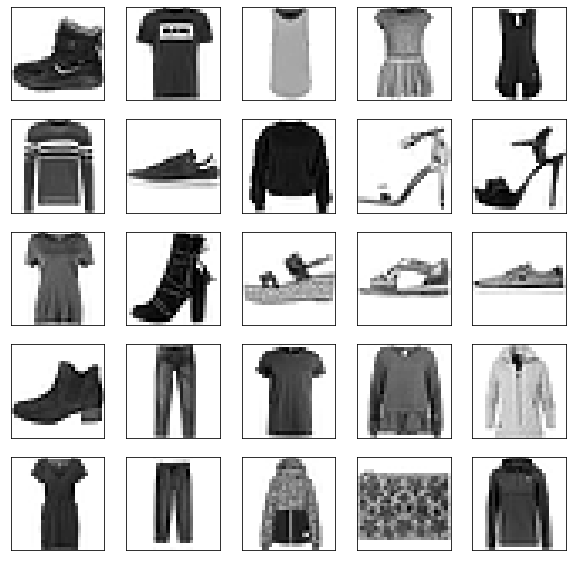

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xtrain[i], cmap=plt.cm.binary)
#plt.tight_layout()
plt.show()

## Task 3: Create Batches of Training Data

In [4]:
print(f"Training size: {xtrain.shape[0]} with {ytrain.shape[0]} labels")
print(f"Test size: {xtest.shape[0]} | image size: {xtrain.shape[1]}x{xtrain.shape[2]} px")
bs = 500
epochs = 50
no_feat = 100
dataset = tf.data.Dataset.from_tensor_slices(xtrain).shuffle(1000)
dataset = dataset.batch(bs, drop_remainder=True).prefetch(1)

Training size: 60000 with 60000 labels
Test size: 10000 | image size: 28x28 px


## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [5]:
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[no_feat]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
])


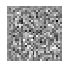

In [6]:
# Normally distributed noise...[image_at_a_time, no. of feats]
noise = tf.random.normal(shape=[1, no_feat])
gen_img = generator(noise, training=False)
plot_utils.show(gen_img, 1)

In [7]:
#generator.summary()

## Task 5: Build the Discriminator Network for DCGAN

In [8]:
# Discriminator is basically CNN based classifier
disc = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
#disc.summary()

In [10]:
decision = disc(gen_img)
print(decision)

tf.Tensor([[0.49818215]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [11]:
disc.compile(loss='binary_crossentropy', optimizer='rmsprop')
# When we're training gen. we dont want disc to be trained at the same time!
disc.trainable = False
gan = keras.models.Sequential([generator, disc])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [12]:
#gan.summary()

## Task 7: Define Training Procedure

In [13]:
# Seed of random gaussian noise
seed = tf.random.normal(shape=[bs, no_feat])

In [14]:
# For each iteration of training
# First train the disc network after that train the gen network
# After k steps, we generate noise images and real images, passit to gen network to identify the real or fake
# Pick a gradient step using these mini-batches of real-fake images and update the params
def train_dcgan(gan, dataset, bs, no_feat, epochs=epochs):
    generator, disc = gan.layers
    for e in tqdm(range(epochs)):
        print(f"Epoch {e+1}/{epochs}")
        for xbatch in dataset:
            noise = tf.random.normal(shape=[bs, no_feat])
            gen_img = generator(noise)
            # Create a DS of real-fake images to train disc on
            xfakeNreal = tf.concat([gen_img, xbatch], axis=0)
            ylab = tf.constant([[0.]]*bs + [[1.]]*bs)
            disc.trainable = True
            disc.train_on_batch(xfakeNreal, ylab)
            # For training GAn, we'll use only Real images!!
            ylab2 = tf.constant([[1.]]*bs)
            disc.trainable = False
            gan.train_on_batch(noise, ylab2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, e+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [15]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [16]:
xtrain_dcgan = xtrain.reshape(-1, 28, 28, 1)*2. -1.

In [17]:
dataset = tf.data.Dataset.from_tensor_slices(xtrain_dcgan).shuffle(1000)
dataset = dataset.batch(bs, drop_remainder=True).prefetch(1)

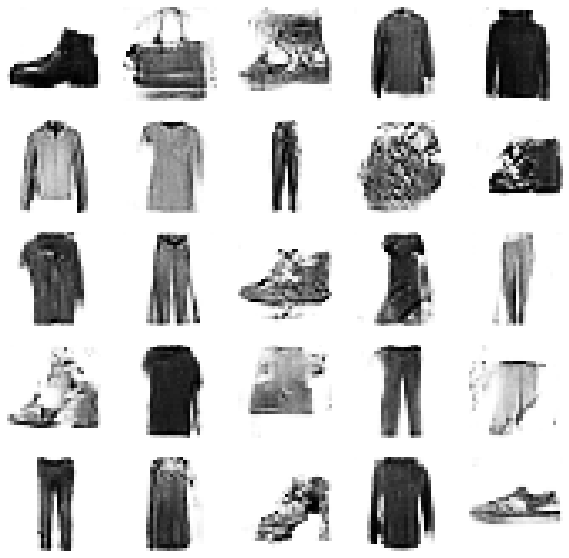

CPU times: user 4min 44s, sys: 16.6 s, total: 5min 1s
Wall time: 19min 16s


In [18]:
%%time
train_dcgan(gan, dataset, bs, no_feat, epochs=epochs)

## Task 9: Generate Synthetic Images with DCGAN

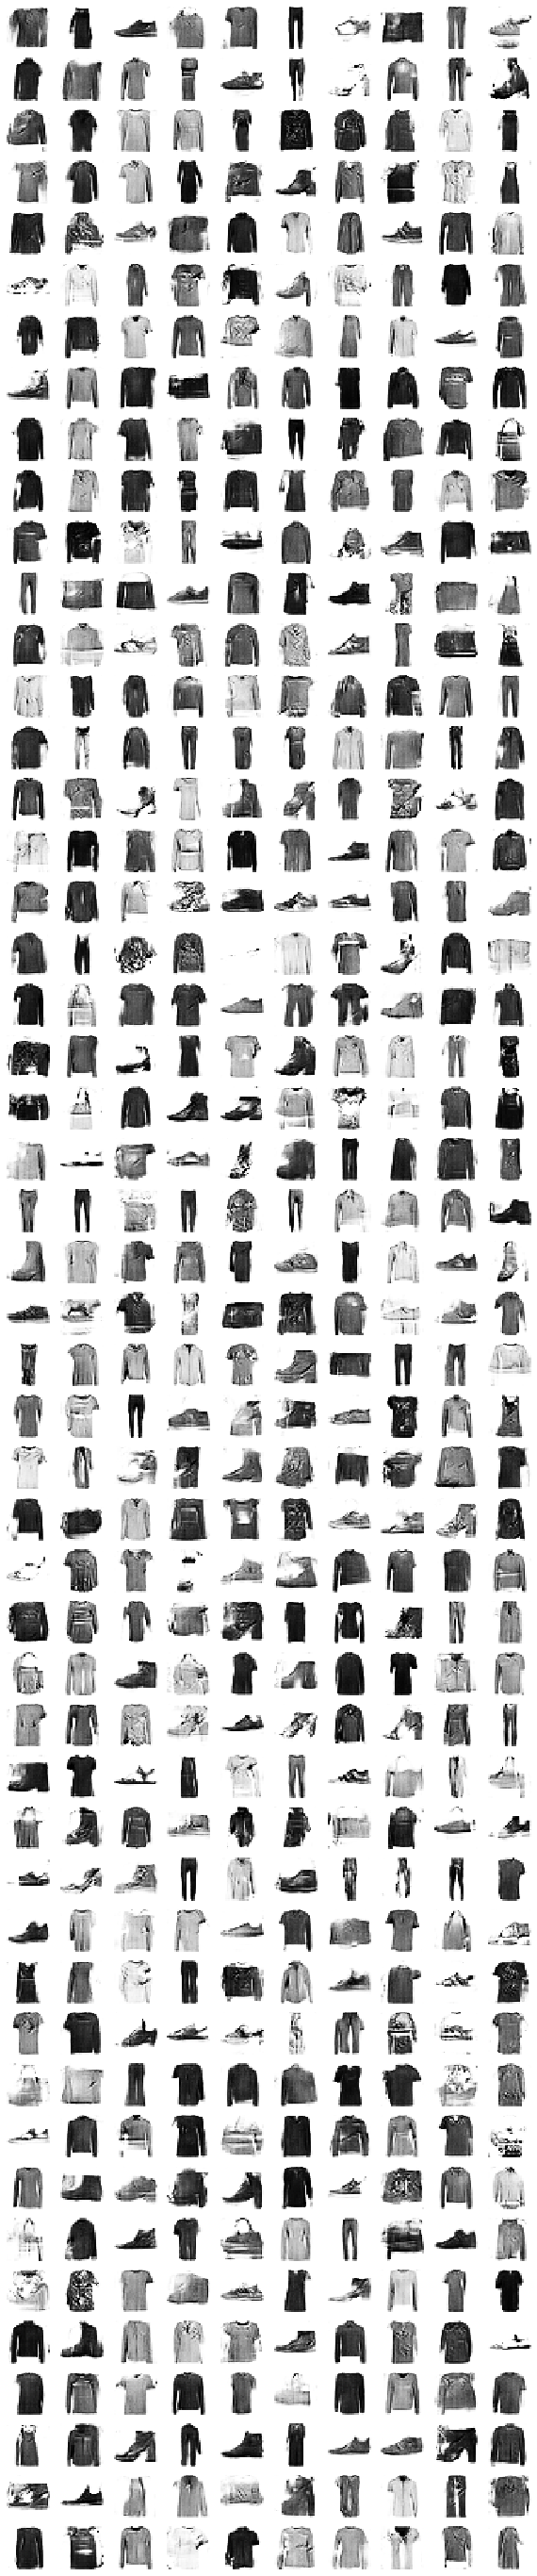

In [19]:
noise = tf.random.normal(shape=[bs, no_feat])
gen_img = generator(noise)
plot_utils.show(gen_img, 10)

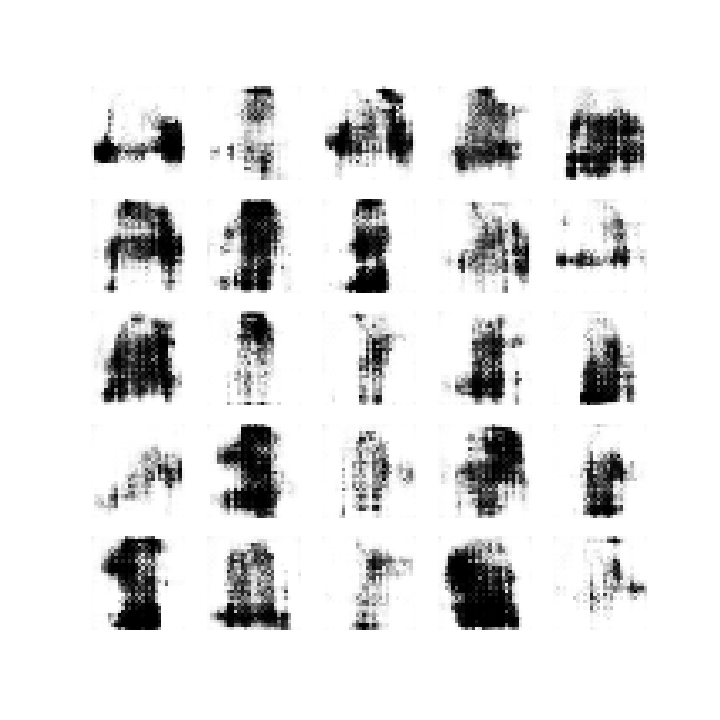

In [20]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)